<a href="https://colab.research.google.com/github/harshalzate/RUL_Jet_Engine/blob/main/RUL_Prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run to Failure degradation simulation of NASA Turbo Jet Engine Fans

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import QuantileTransformer , PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from keras.layers import Dense , LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
cmap = cm.get_cmap('Spectral') # Colour map (there are many others)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import pickle

# <a id='data_analysis'>1. Data analysis</a>
<a href='#index'>Go back to Index</a>

In [17]:
#RUL_1=pd.read_csv("RUL_FD001.txt",header=None)
#RUL_2=pd.read_csv("RUL_FD002.txt",header=None)
#RUL_3=pd.read_csv("RUL_FD003.txt",header=None)
#RUL_4=pd.read_csv("RUL_FD004.txt",header=None)

In [18]:
Train_1=pd.read_csv('train_FD001.txt', sep=" ", header=None)
#Train_2=pd.read_csv('train_FD002.txt', sep=" ", header=None)
#Train_3=pd.read_csv('train_FD003.txt', sep=" ", header=None)
#Train_4=pd.read_csv('train_FD004.txt', sep=" ", header=None)

In [19]:
Test_1 = pd.read_csv('test_FD001.txt', sep=" ", header=None)
#Test_2 = pd.read_csv('test_FD002.txt', sep=" ", header=None)
#Test_3 = pd.read_csv('test_FD003.txt', sep=" ", header=None)
#Test_4 = pd.read_csv('test_FD004.txt', sep=" ", header=None)

In [20]:
#df=pd.concat([Train_1,Train_2,Train_3,Train_4])
df=Train_1.copy()

In [21]:
#columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
#           'Nc','epr','Ps3 0','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]
#delete NaN values
df.drop(columns=[26,27],inplace=True)
columns = ["Section-{}".format(i)  for i in range(26)]
df.columns = columns
df.head()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


#### Dataset statistics  for each parameter

In [22]:
df.describe()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [23]:
df.head(5)

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [24]:
df.columns

Index(['Section-0', 'Section-1', 'Section-2', 'Section-3', 'Section-4',
       'Section-5', 'Section-6', 'Section-7', 'Section-8', 'Section-9',
       'Section-10', 'Section-11', 'Section-12', 'Section-13', 'Section-14',
       'Section-15', 'Section-16', 'Section-17', 'Section-18', 'Section-19',
       'Section-20', 'Section-21', 'Section-22', 'Section-23', 'Section-24',
       'Section-25'],
      dtype='object')

## <a id='info_about_data'>1.1 Info about data:</a>
- Section-0 is MachineID
- Section-1 is time in, Cycles
- Section-2...4 is Opertional Settings
- Section-5...25 is sensor's data


- Data Set: FD001
- Train trjectories: 100
- Test trajectories: 100
- Conditions: ONE (Sea Level)
- Fault Modes: ONE (HPC Degradation)

In [25]:
# Names
MachineID_name = ["Section-0"]
RUL_name = ["Section-1"]
OS_name = ["Section-{}".format(i) for i in range(2,5)]
Sensor_name = ["Section-{}".format(i) for i in range(5,26)]

# Data in pandas DataFrame
MachineID_data = df[MachineID_name]
RUL_data = df[RUL_name]
OS_data = df[OS_name]
Sensor_data = df[Sensor_name]

# Data in pandas Series
MachineID_series = df["Section-0"]
RUL_series = df["Section-1"]

In [26]:
grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])

In [27]:
#delete columns with constant values that do not carry information about the state of the unit
#data = pd.concat([RUL_data,OS_data,Sensor_data], axis=1)
df.drop(columns=["Section-0",
                "Section-4", # Operatinal Setting
                "Section-5", # Sensor data
                "Section-9", # Sensor data
                "Section-10", # Sensor data
                "Section-14",# Sensor data
                "Section-20",# Sensor data
                "Section-22",# Sensor data
                "Section-23"] , inplace=True)

From the above vizulization its clear that
- Section-4 (Oprational Setting-3)
- Section-5 (Sensor-1)
- Section-9  (Sensor-5)
- Section-14 (Sensor-10)
- Section-20 (Sensor-16)
- Section-22 (Sensor-18)
- Section-23 (Sensor-19)

Does not play a vital role in variation of data and there std is also almost 0 so, these sensor data is useless for us hence, we can drop this coloumn data

In [28]:
df.head(10)

,Section-1,Section-2,Section-3,Section-6,Section-7,Section-8,Section-11,Section-12,Section-13,Section-15,Section-16,Section-17,Section-18,Section-19,Section-21,Section-24,Section-25
0,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044
5,6,-0.0043,-0.0001,642.10,1584.47,1398.37,554.67,2388.02,9049.68,47.16,521.68,2388.03,8132.85,8.4108,391,38.98,23.3669
6,7,0.0010,0.0001,642.48,1592.32,1397.77,554.34,2388.02,9059.13,47.36,522.32,2388.03,8132.32,8.3974,392,39.10,23.3774
7,8,-0.0034,0.0003,642.56,1582.96,1400.97,553.85,2388.00,9040.80,47.24,522.47,2388.03,8131.07,8.4076,391,38.97,23.3106
8,9,0.0008,0.0001,642.12,1590.98,1394.80,553.69,2388.05,9046.46,47.29,521.79,2388.05,8125.69,8.3728,392,39.05,23.4066
9,10,-0.0033,0.0001,641.71,1591.24,1400.46,553.59,2388.05,9051.70,47.03,521.79,2388.06,8129.38,8.4286,393,38.95,23.4694


# <a id='noise_removal'>2. Noise removal and Normalization</a>
<a href='#index'>Go back to Index</a>

In [29]:
print(type(df))
gen = MinMaxScaler(feature_range=(0, 1))
df = gen.fit_transform(df)
df = pd.DataFrame(df)
#df = df.rolling(20).mean()
pt = PowerTransformer()
df = pt.fit_transform(df)

<class 'pandas.core.frame.DataFrame'>


In [30]:
df=np.nan_to_num(df)

In [31]:
df

array([[-1.84688137, -0.31975365, -1.3916867 , ..., -0.76399955,
         1.42665355,  1.24248381],
       [-1.82422371,  0.87202066, -1.03174892, ..., -0.76399955,
         1.03734696,  1.29226848],
       [-1.80166973, -1.9503069 ,  1.01385485, ..., -2.35059786,
         0.72414823,  0.465476  ],
       ...,
       [ 1.25582441,  0.18308976,  0.01311911, ...,  2.66650739,
        -1.90974435, -2.75272539],
       [ 1.26682846, -0.50209065,  1.01385485, ...,  1.14636389,
        -2.49938469, -1.91568423],
       [ 1.27779988, -1.45465135, -1.75831429, ...,  1.68933126,
        -2.19492018, -1.99819889]])

In [32]:
# grouping w.r.t MID (Machine ID)
# col_names = df.columns
# def grouping(datafile, mid_series):
#     data = [x for x in datafile.groupby(mid_series)]
#     return data

# <a id='training_and_validation'>3. Training and Validation</a>
<a href='#index'>Go back to Index</a>

In [33]:
def RUL_df():
    rul_lst = [j  for i in MachineID_series.unique() for j in np.array(grp.get_group(i)[::-1]["Section-1"])]
    rul_col = pd.DataFrame({"rul":rul_lst})
    return rul_col
RUL_df().head()

,rul
0,192
1,191
2,190
3,189
4,188


## <a id='3.1'>3.1 Training Performance of different models</a>
<a href='#index'>Go back to Index</a>

In [34]:
X = np.array(df)
y = np.array(RUL_df()).reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
forest_model = RandomForestRegressor()
forest_model.fit(X_train, y_train)
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression()

In [35]:
pred_f = forest_model.predict(X)
pred_lin = lin_model.predict(X)
pred_log = logistic_model.predict(X)

print("mean_squared_error >> ", mean_squared_error(y, pred_f))
print("mean_absolute_error >>",mean_absolute_error(y, pred_f))

print("\nmean_squared_error >> ", mean_squared_error(y, pred_lin))
print("mean_absolute_error >>",mean_absolute_error(y, pred_lin))

print("\nmean_squared_error >> ", mean_squared_error(y, pred_log))
print("mean_absolute_error >>",mean_absolute_error(y, pred_log))

mean_squared_error >>  407.3293051039698
mean_absolute_error >> 12.624014347341378

mean_squared_error >>  1523.038811067161
mean_absolute_error >> 29.359995359682824

mean_squared_error >>  1731.6363724492269
mean_absolute_error >> 28.745480102757984


In [99]:
pickle.dump(logistic_model, open('logistic_regression.sav', 'wb'))
pickle.dump(lin_model, open('linear_regression.sav', 'wb'))
pickle.dump(forest_model, open('forest_regression.sav', 'wb'))

In [37]:
print("Acc of Linear Regression >> ",lin_model.score(X_test, y_test))
print("Acc of Random Forest >> ",forest_model.score(X_test, y_test))
print("Acc of Logistic Regression >> ",logistic_model.score(X_test, y_test))

Acc of Linear Regression >>  0.6853050494213571
Acc of Random Forest >>  0.7267223348753207
Acc of Logistic Regression >>  0.01938454082868912


## <a id='3.2'>3.2 Random Forest</a>
<a href='#index'>Go back to Index</a>

### <a id='3.2.1'>3.2.1 Random Forest Validation Performance</a>

In [38]:
forest_pred = forest_model.predict(X_test)
print("mean_squared_error >> ", mean_squared_error(y_test, forest_pred))
print("mean_absolute_error >>",mean_absolute_error(y_test, forest_pred))

mean_squared_error >>  1295.3454645262902
mean_absolute_error >> 25.35087230433729


### <a id='3.2.2'>3.2.2 Random Forest Validation Prediction vs Actual</a>

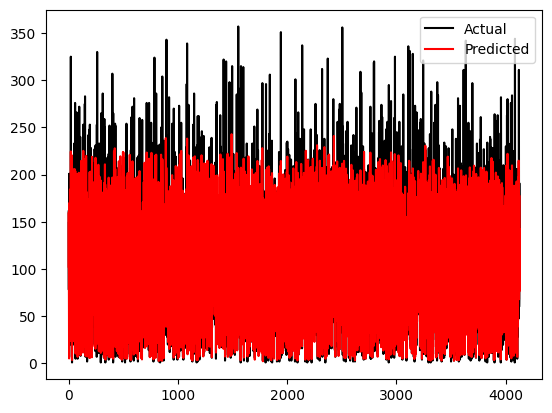

In [39]:
plt.plot(y_test,c='k',label='Actual')
plt.plot(forest_pred,c='red',label='Predicted')
plt.legend()
plt.show()

## <a id='3.3'>3.3 Linear Regression</a>
<a href='#index'>Go back to Index</a>

### <a id='3.3.1'>3.3.1 Linear Regression Validation Performance</a>

In [40]:
lin_pred = lin_model.predict(X_test)
print("mean_squared_error >> ", mean_squared_error(y_test, lin_pred))
print("mean_absolute_error >>",mean_absolute_error(y_test, lin_pred))

mean_squared_error >>  1491.6648118879032
mean_absolute_error >> 29.150854429340946


### <a id='3.3.2'>3.3.2 Linear Regression Validation Prediction vs Actual</a>

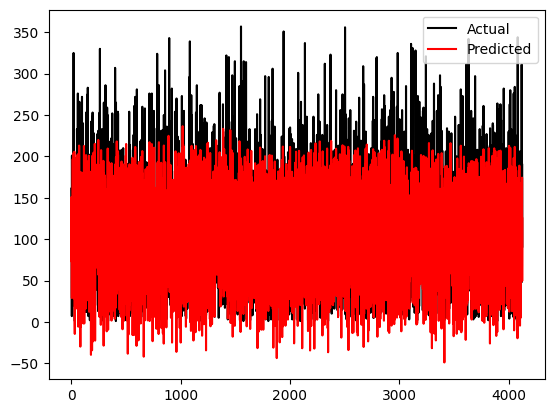

In [41]:
plt.plot(y_test,c='k',label='Actual')
plt.plot(lin_pred,c='red',label='Predicted')
plt.legend()
plt.show()

## <a id='3.4'>3.4 Logistic Regression </a>
<a href='#index'>Go back to Index</a>

### <a id='3.4.1'>3.4.1 Logistic Regression Validation Performance</a>

In [214]:
logistic_pred = logistic_model.predict(X_test)
print("mean_squared_error >> ", mean_squared_error(y_test, logistic_pred))
print("mean_absolute_error >>", mean_absolute_error(y_test, logistic_pred))

mean_squared_error >>  1689.5805669978192
mean_absolute_error >> 28.961230918342622


### <a id='3.4.2'>3.4.2 Logistic Regression Validation Prediction vs Actual</a>

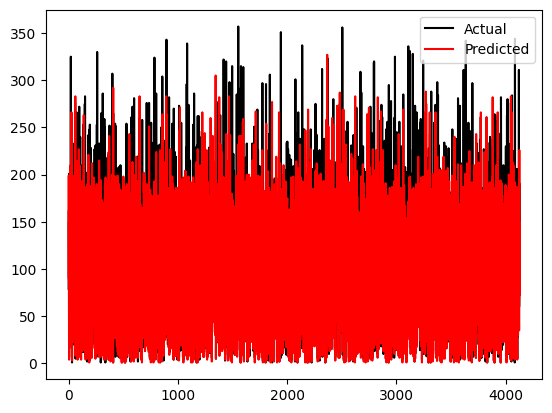

In [43]:
plt.plot(y_test,c='k',label='Actual')
plt.plot(logistic_pred,c='red',label='Predicted')
plt.legend()
plt.show()

In [44]:
# from sklearn.linear_model import LinearRegression
# linear_reg = LinearRegression()
# linear_reg.fit(trainX,trainY)

In [45]:
# print("acc of Linear Regressor >> ",linear_reg.score(testX, testY))

# Hyper parameter Tuning

In [46]:
rf_regressor = RandomForestRegressor(random_state=42)

# Define the hyperparameters grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Evaluate the model on the test set
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Mean Squared Error on Test Set: 1258.1363214702674


In [54]:
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)

Mean Squared Error on Test Set: 1258.1363214702674


In [55]:
mse

1258.1363214702674

In [56]:
rmse = np.sqrt(mse)
rmse

35.470217386848184

In [50]:
mae = mean_absolute_error(y_test, y_pred)
mae

24.994833199441164

In [100]:
pickle.dump(best_rf_model, open('Tuned_rf_model.sav', 'wb'))

# <a id='testing'>4 Testing</a>
<a href='#index'>Go back to Index</a>

In [126]:
forest_model = pickle.load(open('forest_regression.sav', 'rb'))
lin_model = pickle.load(open('linear_regression.sav', 'rb'))
logistic_model = pickle.load(open('logistic_regression.sav', 'rb'))

best_rf_model = pickle.load(open('Tuned_rf_model.sav', 'rb'))

In [127]:
#df_test = pd.read_csv(test_file, sep=" ",header = None)
#df_test.drop(columns=[26,27],inplace=True)
#df_test.columns = columns
#df_test.head()

In [128]:
df_test = pd.read_csv('test_FD001.txt', sep=" ",header = None)
df_test.drop(columns=[26,27],inplace=True)
df_test.columns = columns
df_test.head()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [129]:
#df_rul = pd.read_csv(RUL_file, names=['rul'])
#df_rul.head()

In [130]:
df_rul = pd.read_csv("RUL_FD001.txt", names=['rul'])
df_rul.head(5)

,rul
0,112
1,98
2,69
3,82
4,91


In [171]:
RUL_name = ["Section-1"]
RUL_data = df_test[RUL_name]
MachineID_series = df_test["Section-0"]
grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])
max_cycles # Finding out the max cycles for which the one purticular engine ran

array([ 31,  49, 126, 106,  98, 105, 160, 166,  55, 192,  83, 217, 195,
        46,  76, 113, 165, 133, 135, 184, 148,  39, 130, 186,  48,  76,
       140, 158, 171, 143, 196, 145,  50, 203, 198, 126, 121, 125,  37,
       133, 123, 156, 172,  54, 152, 146,  73,  78, 303,  74, 144, 189,
       164, 121, 113, 136, 160, 176,  94, 147, 159, 232, 155, 168,  71,
       147,  71, 187,  54, 152,  68, 131, 112, 137,  88, 205, 162,  72,
       101, 133, 213, 162,  73, 172,  34, 110,  56,  68, 177, 146, 234,
       150, 244, 133,  89,  97, 134, 121,  97, 198])

In [81]:
df_test.drop(df_test[["Section-0",
                "Section-4", # Operatinal Setting
                "Section-5", # Sensor data
                "Section-9", # Sensor data
                "Section-10", # Sensor data
                "Section-14",# Sensor data
                "Section-20",# Sensor data
                "Section-22",# Sensor data
                "Section-23"]], axis=1 , inplace=True)
#df_test = df_test.groupby(["Section-0"])
#print(df_test)

In [82]:
gen = MinMaxScaler(feature_range=(0, 1))
df_test = gen.fit_transform(df_test)
df_test = pd.DataFrame(df_test)
#df_test = df_test.rolling(20).mean()
pt = PowerTransformer()
df_test = pt.fit_transform(df_test)
df_test = np.nan_to_num(df_test)

In [141]:
df_test.head(5)

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [138]:
df_test.shape

(13096, 26)

## <a id='4.1'>4.1 Random Forest Testing</a>
<a href='#index'>Go back to Index</a>

In [104]:
forest_pred = best_rf_model.predict(df_test)

In [105]:
forest_pred = np.array(forest_pred)

In [106]:
forest_pred = forest_pred.flatten()

In [107]:
forest_pred = forest_pred.reshape(forest_pred.shape[0],1)

In [108]:
forest_pred.shape

(13096, 1)

In [208]:
df_test[:32]

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
5,1,6,0.0012,0.0003,100.0,518.67,642.11,1579.12,1395.13,14.62,...,521.92,2388.08,8127.46,8.4238,0.03,392,2388,100.0,38.91,23.3467
6,1,7,-0.0000,0.0002,100.0,518.67,642.11,1583.34,1404.84,14.62,...,522.01,2388.06,8134.97,8.3914,0.03,391,2388,100.0,38.85,23.3952
7,1,8,0.0006,-0.0000,100.0,518.67,642.54,1580.89,1400.89,14.62,...,522.09,2388.06,8125.93,8.4213,0.03,393,2388,100.0,39.05,23.3224
8,1,9,-0.0036,0.0000,100.0,518.67,641.88,1593.29,1412.28,14.62,...,522.03,2388.05,8134.15,8.4353,0.03,391,2388,100.0,39.10,23.4521
9,1,10,-0.0025,-0.0001,100.0,518.67,642.07,1585.25,1398.64,14.62,...,522.00,2388.06,8134.08,8.4093,0.03,391,2388,100.0,38.87,23.3820


In [196]:
forest_pred[0]

array([186.3631851])

In [110]:
final_forest_pred = []
count = 0
for i in range(100):
    temp = 0
    j = max_cycles[i]
    while j>0:
        temp = temp + forest_pred[count]
        j=j-1
        count=count+1
    final_forest_pred.append(temp/max_cycles[i])     ##

In [111]:
final_forest_pred=np.array(final_forest_pred)
final_forest_pred = final_forest_pred.flatten()

In [177]:
final_forest_pred.shape

(100,)

In [203]:
forest_pred[:31].sum()/31

177.46481065086857

In [199]:
final_forest_pred[0]

177.46481065086857

In [212]:
df_rul[0:]

,rul
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


In [220]:
from google.colab import files
files.download('forest_regression.sav')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

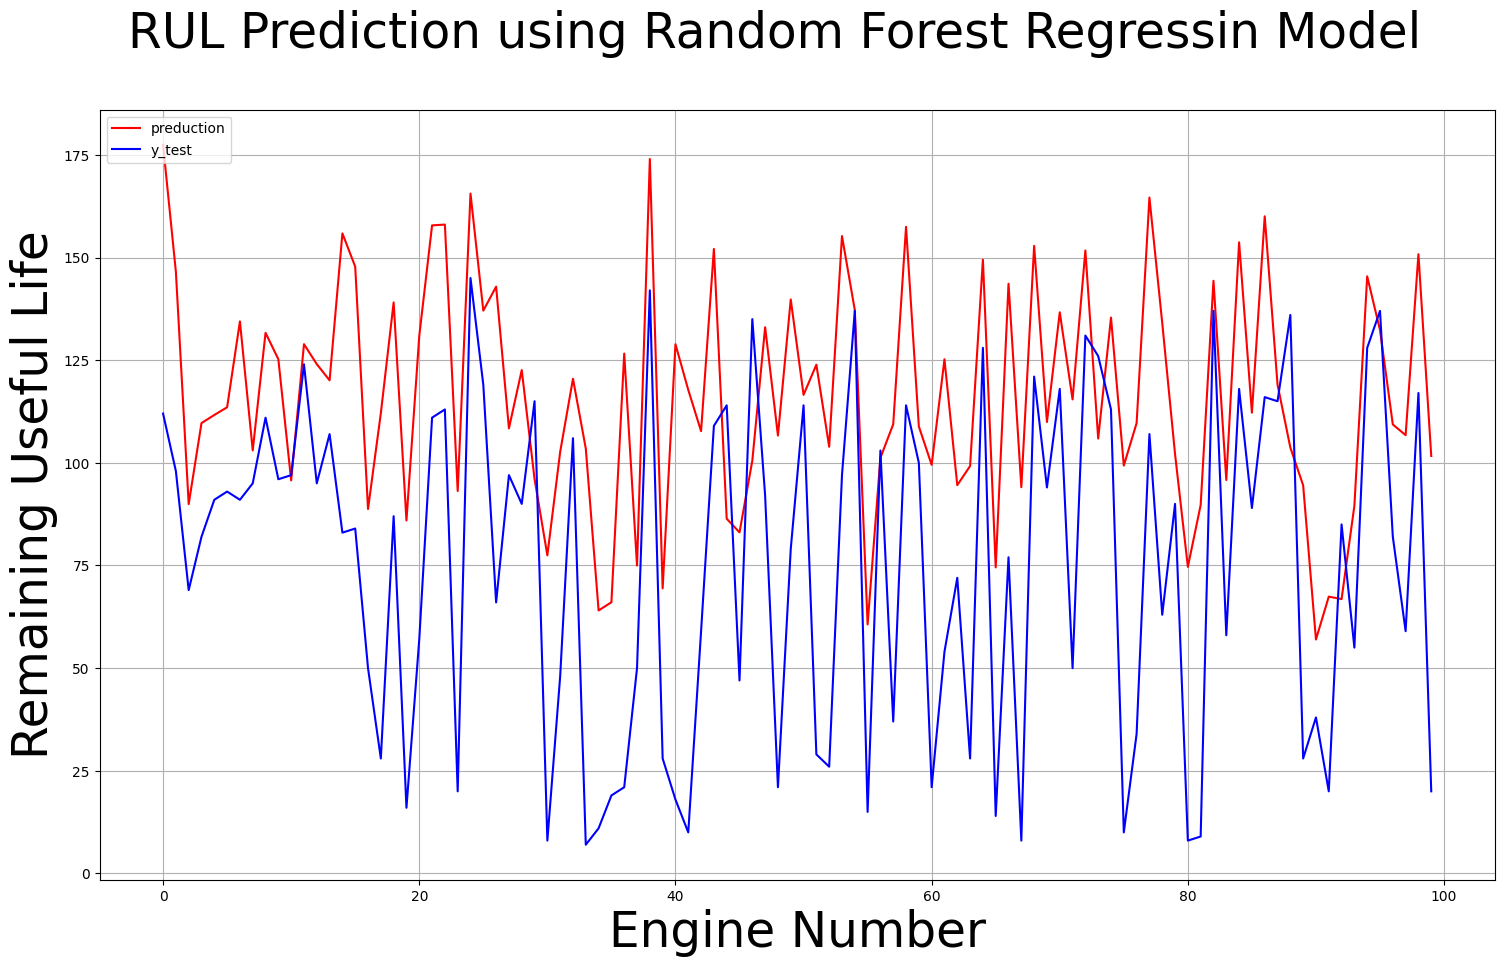

In [113]:
fig = plt.figure(figsize=(18,10))
plt.plot(final_forest_pred,c='red',label='preduction')
plt.plot(df_rul,c='blue',label='y_test')
fig.suptitle('RUL Prediction using Random Forest Regressin Model', fontsize=35)
plt.xlabel("Engine Number", fontsize=35)
plt.ylabel("Remaining Useful Life", fontsize=35)
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [221]:
print("mean_squared_error >> ", mean_squared_error(df_rul,final_forest_pred))
print("root mean_absolute_error >>",math.sqrt(mean_squared_error(df_rul,final_forest_pred)))
print("mean_absolute_error >>",mean_absolute_error(df_rul,final_forest_pred))

mean_squared_error >>  2697.1703536674445
root mean_absolute_error >> 51.93428880486807
mean_absolute_error >> 44.025316835986295
